# Pengenalan Semantic Segmentation (Segmentasi Semantik)
Segmentasi Semantik adalah tugas dalam computer vision di mana kita mengklasifikasikan setiap piksel dari sebuah gambar ke dalam kelas tertentu. Berbeda dengan klasifikasi gambar yang memberikan satu label untuk keseluruhan gambar, segmentasi memberikan pemahaman mendetail hingga ke tingkat piksel.

Dalam tutorial ini, kita akan:

1. Menggunakan dataset COCO (Common Objects in Context), sebuah dataset kompleks berskala besar dengan banyak kategori objek.

2. Mengimplementasikan U-Net, sebuah arsitektur yang populer dan efektif untuk tugas segmentasi.

3. Membangun alur kerja lengkap di PyTorch, mulai dari memuat data, melatih model, hingga memvisualisasikan prediksi.

## Install Packages

In [8]:
# Install required libraries
!pip install -q torch torchvision
!pip install -q albumentations
!pip install -q segmentation-models-pytorch
!pip install -q pycocotools
!pip install -q timm

### **Penjelasan**

  * **`torch` & `torchvision`**: Library PyTorch untuk operasi tensor dan membangun jaringan saraf. `torchvision` nantinya bakal digunain untuk ngambil dataset yang akan dipakai.
  * **`albumentations`**: Library ini dirancang khusus untuk menangani augmentasi pada tugas seperti segmentasi, di mana gambar dan mask (peta segmentasi) yang sesuai harus ditransformasikan secara identik.
  * **`segmentation-models-pytorch`**: Sebuah library tingkat tinggi yang menyediakan model-model segmentasi yang sudah diimplementasikan (seperti U-Net, FPN, dll.) dengan berbagai *backbone pre-training* (seperti ResNet, VGG, dll.). Ini mempermudah kita agar tidak perlu menulis arsitektur model dari awal.
  * **`pycocotools`**: Library utilitas untuk membantu membaca dan bekerja dengan format anotasi dataset COCO.

## Import Datasets

In [14]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Download COCO 2017 dataset (images and annotations)
!wget -q http://images.cocodataset.org/zips/val2017.zip
!wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q val2017.zip
!unzip -q annotations_trainval2017.zip

replace val2017/000000212226.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
a
replace annotations/instances_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
a


In [15]:
class CocoDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transforms=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            annotation_file (string): Path to the coco annotation file.
            transforms (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.coco = COCO(annotation_file)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transforms = transforms

        # We are only interested in the 'person' category
        self.person_cat_id = self.coco.getCatIds(catNms=['person'])[0]
        # Filter image ids to only include those with 'person' annotations
        self.img_ids = self.coco.getImgIds(catIds=[self.person_cat_id])


    def __getitem__(self, index):
        # Get the image id for the current index
        img_id = self.img_ids[index]

        # Load image metadata
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert to RGB

        # Create the segmentation mask
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        ann_ids = self.coco.getAnnIds(imgIds=img_info['id'], catIds=[self.person_cat_id], iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)

        # Combine all person instance masks into a single binary mask
        for ann in anns:
            mask = np.maximum(self.coco.annToMask(ann), mask)

        # Apply augmentations
        if self.transforms:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            # Add a channel dimension to the mask
            mask = mask.unsqueeze(0)

        return image, mask

    def __len__(self):
        return len(self.img_ids)

## Augmentations and Data Loaders

In [16]:
# Vision Transformer models work best with 224x224 resolution
IMG_SIZE = 224

data_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# Create the dataset instance
DATA_DIR = 'val2017'
ANNOTATION_FILE = 'annotations/instances_val2017.json'
dataset = CocoDataset(root_dir=DATA_DIR, annotation_file=ANNOTATION_FILE, transforms=data_transforms)

# Split dataset into training and validation (e.g., 80/20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

print(f"Total images with 'person' category: {len(dataset)}")
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

loading annotations into memory...
Done (t=1.30s)
creating index...
index created!
Total images with 'person' category: 2693
Training samples: 2154, Validation samples: 539


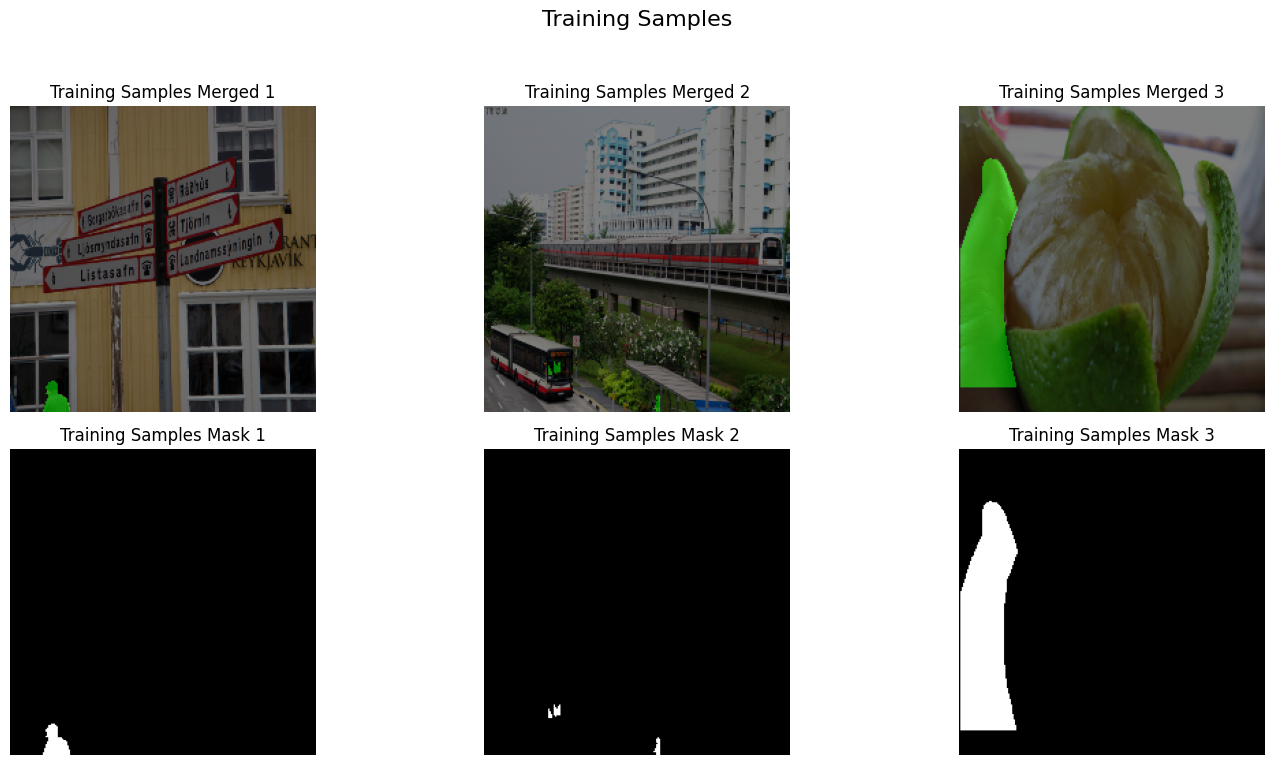

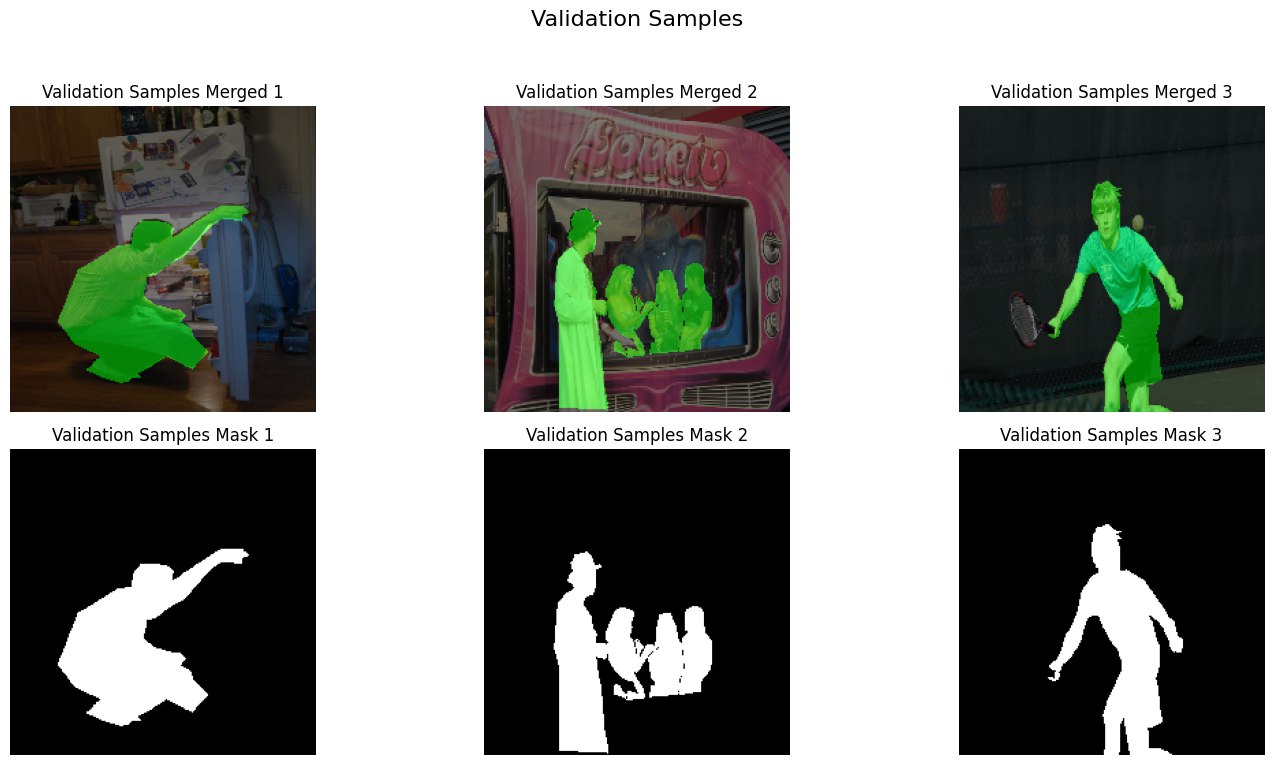

In [17]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def visualize_sample(image, mask, title):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image.permute(1, 2, 0)) # Permute to HWC format for matplotlib
    ax[0].set_title(f'{title} Image')
    ax[0].axis('off')

    ax[1].imshow(mask.squeeze(), cmap='gray') # Squeeze to remove channel dimension
    ax[1].set_title(f'{title} Mask')
    ax[1].axis('off')
    plt.show()

def display_samples(data_loader, title, num_samples=3):
    images, masks = next(iter(data_loader))
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))
    fig.suptitle(title, fontsize=16)

    for i in range(num_samples):
        # Display image
        img = images[i].permute(1, 2, 0).cpu().numpy()
        # Denormalize image for display
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        # Get mask and convert to numpy
        mask = masks[i].squeeze().cpu().numpy().astype(np.uint8)

        # Create a merged visualization
        # Convert mask to a color mask (e.g., green)
        colored_mask = np.zeros_like(img)
        colored_mask[mask == 1] = [0, 1, 0] # Green color for the mask

        # Blend the original image with the colored mask
        alpha = 0.5  # Transparency factor
        merged_image = (img * (1 - alpha) + colored_mask * alpha).astype(np.float32)


        axes[0, i].imshow(merged_image)
        axes[0, i].set_title(f'{title} Merged {i+1}')
        axes[0, i].axis('off')

        # Display mask
        axes[1, i].imshow(mask, cmap='gray')
        axes[1, i].set_title(f'{title} Mask {i+1}')
        axes[1, i].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

# Display samples from training and validation sets
display_samples(train_loader, 'Training Samples', num_samples=3)
display_samples(val_loader, 'Validation Samples', num_samples=3)

## Define Model and Tuning

In [30]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [31]:
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import CosineAnnealingLR

model = smp.Unet(
    encoder_name="mit_b5", # Changed to a supported timm encoder
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation='sigmoid'
).to(DEVICE)

# Define Loss, Optimizer, Scheduler, and Metrics
loss_fn = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

## Training Model

In [32]:
def train_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device).float()

        # Forward pass
        predictions = model(images)
        loss = loss_fn(predictions, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

def validate_epoch(loader, model, loss_fn, device):
    model.eval()
    running_loss = 0.0
    total_iou = 0.0

    with torch.no_grad():
        for images, masks in loader:
            # Ensure masks are Long type for get_stats function
            images, masks = images.to(device), masks.to(device).long()

            # Get model predictions
            predictions = model(images)

            # Calculate loss (loss function still needs float masks)
            loss = loss_fn(predictions, masks.float())

            # METRIC CALCULATION FIX
            # Create binary masks from predictions for calculating stats
            pred_masks = (predictions > 0.5).long()

            # Get the statistics (true positives, false positives, etc.)
            tp, fp, fn, tn = smp.metrics.get_stats(pred_masks, masks, mode='binary')

            # Calculate IoU score from the stats
            iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction='micro')
            # END OF FIX

            running_loss += loss.item() * images.size(0)
            total_iou += iou_score.item() * images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_iou = total_iou / len(loader.dataset)
    return epoch_loss, epoch_iou

In [33]:
NUM_EPOCHS = 15
print(f"Starting training for {NUM_EPOCHS} epochs...")

for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(train_loader, model, optimizer, loss_fn, DEVICE)
    val_loss, val_iou = validate_epoch(val_loader, model, loss_fn, DEVICE)

    # Update the learning rate scheduler
    scheduler.step()

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} -> Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")

print("Training finished.")

Starting training for 15 epochs...
Epoch 1/15 -> Train Loss: 0.6985, Val Loss: 0.6772, Val IoU: 0.5853
Epoch 2/15 -> Train Loss: 0.6847, Val Loss: 0.6718, Val IoU: 0.6112
Epoch 3/15 -> Train Loss: 0.6799, Val Loss: 0.6678, Val IoU: 0.6833
Epoch 4/15 -> Train Loss: 0.6760, Val Loss: 0.6687, Val IoU: 0.6958
Epoch 5/15 -> Train Loss: 0.6749, Val Loss: 0.6649, Val IoU: 0.7283
Epoch 6/15 -> Train Loss: 0.6751, Val Loss: 0.6655, Val IoU: 0.7231
Epoch 7/15 -> Train Loss: 0.6726, Val Loss: 0.6647, Val IoU: 0.7421
Epoch 8/15 -> Train Loss: 0.6700, Val Loss: 0.6639, Val IoU: 0.7513
Epoch 9/15 -> Train Loss: 0.6729, Val Loss: 0.6655, Val IoU: 0.6604
Epoch 10/15 -> Train Loss: 0.6709, Val Loss: 0.6634, Val IoU: 0.7238
Epoch 11/15 -> Train Loss: 0.6728, Val Loss: 0.6663, Val IoU: 0.7068
Epoch 12/15 -> Train Loss: 0.6741, Val Loss: 0.6644, Val IoU: 0.7409
Epoch 13/15 -> Train Loss: 0.6713, Val Loss: 0.6640, Val IoU: 0.7184
Epoch 14/15 -> Train Loss: 0.6704, Val Loss: 0.6636, Val IoU: 0.7453
Epoch 15

## Visualization and Prediction

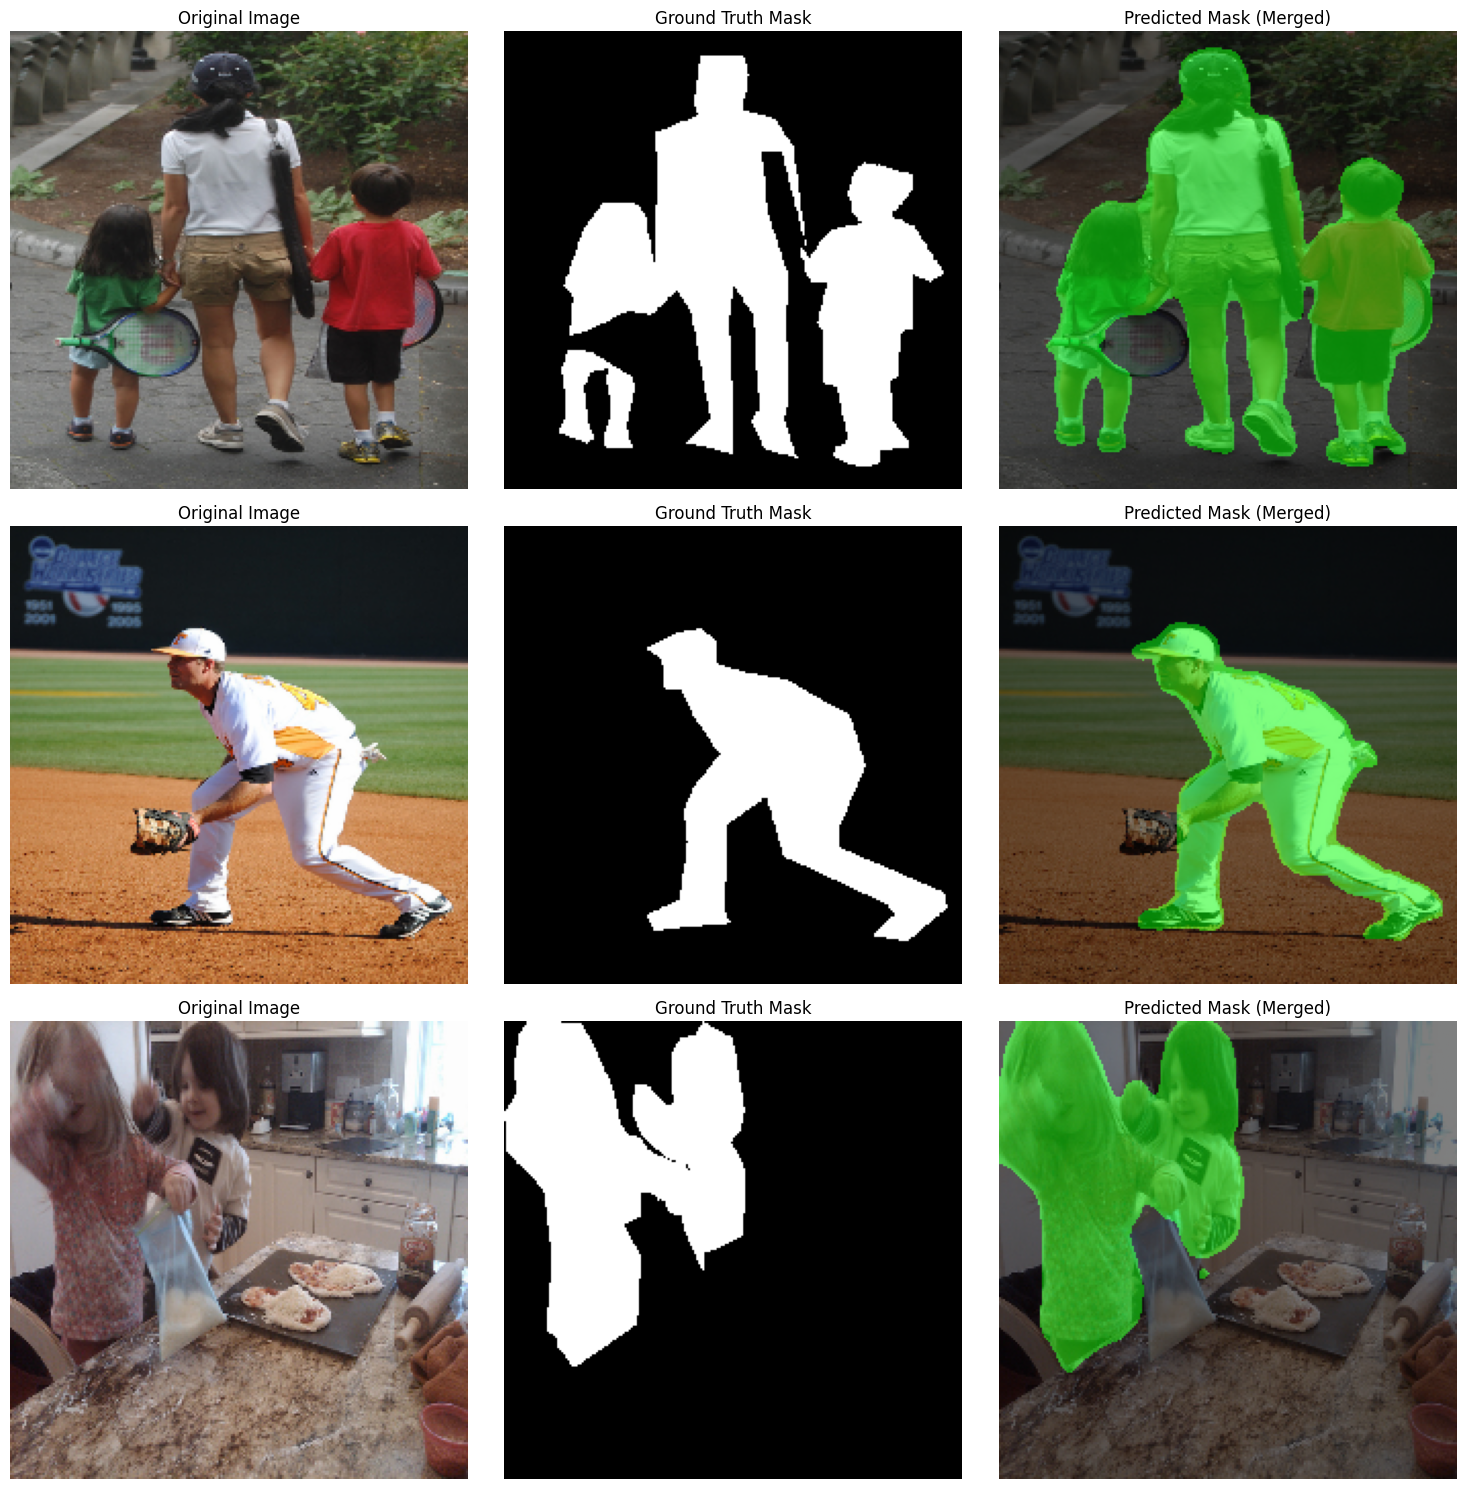

In [34]:
import matplotlib.pyplot as plt

def visualize_prediction(dataset, model, device, num_samples=3):
    model.eval()
    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        # Get a random sample from the dataset
        idx = np.random.randint(0, len(dataset))
        image, mask = dataset[idx]

        with torch.no_grad():
            # Add a batch dimension and move to device
            input_image = image.unsqueeze(0).to(device)

            # Get model prediction
            pred_mask = model(input_image)

            # The output is a probability map, convert it to a binary mask (0 or 1)
            # We use a threshold of 0.5
            pred_mask = (pred_mask > 0.5).float()

        # Move tensors to CPU and convert to NumPy for visualization
        image = image.permute(1, 2, 0).cpu().numpy() # CHW to HWC
        mask = mask.squeeze().cpu().numpy()
        pred_mask = pred_mask.squeeze().cpu().numpy()

        # Denormalize image for correct display
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

        # Create a merged visualization
        # Convert predicted mask to a color mask (e.g., green)
        colored_pred_mask = np.zeros_like(image)
        colored_pred_mask[pred_mask == 1] = [0, 1, 0] # Green color for the mask

        # Blend the original image with the colored predicted mask
        alpha = 0.5  # Transparency factor
        merged_image = (image * (1 - alpha) + colored_pred_mask * alpha).astype(np.float32)


        # Plotting
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(merged_image) # Display the merged image
        plt.title("Predicted Mask (Merged)")
        plt.axis('off')


    plt.tight_layout()
    plt.show()

# Visualize results on the validation set
visualize_prediction(val_dataset.dataset, model, DEVICE, num_samples=3)